In [2]:
import numpy as np
import numpy as np  
from scipy.linalg import expm
import time 
np.random.seed(0)


def Parameter(flow, epsilon, nPart, rcut, N, Nperiod): 

    if nPart < 2:
        raise ValueError("The number of particles is invalid")


    if flow == 'eld':
        if nPart <= 2:
            a = 10
        else:
            a = 2*nPart
        A = np.array([[0,0,0],[0,0,0],[0,0,0]])
        invL0 = np.eye(3)/a
        Y = A
        Yoff = np.zeros((3,3))
        Sigma = 1
    elif flow == 'shear':
        # Shear flow case with LE
        if nPart <= 2:
            a = 10
        else:
            a = 2*nPart
        A = epsilon * np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
        invL0 = np.eye(3) / a
        Y = A
        Yoff = np.zeros((3, 3))
        theta = 1
        Sigma = 1
    elif flow == 'pef':
        # PEF case with KR
        if nPart <= 2:
            a = 20
        else:
            a = 2*nPart

        A = epsilon * np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]])
        M = np.array([[2, -1, 0], [-1, 1, 0], [0, 0, 1]])
        _,V = np.linalg.eig(M)
        V = V[:, [1, 0, 2]]
        Y = np.log(np.diag(np.dot(np.dot(np.linalg.inv(V), M), V)))
        Yoff = np.zeros((3, 3))
        invL0 = V / np.abs(np.linalg.det(V)) ** (1/2) / a
        theta = 1 
        Sigma = epsilon/Y[0] 

    T = 1 / np.abs(Sigma)
    pbc = {}

    pbc['L0inv'] = invL0
    pbc['L0'] = np.linalg.inv(invL0)
    pbc['Linv'] = pbc['L0inv']
    pbc['L'] = pbc['L0']
    pbc['A'] = A
    pbc['Y'] = Y
    pbc['Yoff'] = Yoff
    pbc['Sigma'] = Sigma
    pbc['T'] = 1/abs(Sigma)
    pbc['theta'] = 0
    pbc['theta1'] = 0
    pbc['n'] = 0
    pbc['dt'] = pbc['T'] / N
    pbc['N'] = N
    pbc['Nperiod'] = Nperiod
    pbc['flow'] = flow

    part = {}


    part['q'] = np.zeros((3,nPart))
    part['qDist'] = np.zeros((3,nPart))
    part['p'] = np.zeros((3,nPart))
    part['p'][2,:nPart] = np.zeros(nPart)
    part['f'] = np.zeros((3,nPart))
    part['ff'] = np.zeros(1)
    part['G'] = np.zeros((3,nPart))

    sav = {}

    sav['Q1'] = np.zeros((N,Nperiod))
    sav['Q2'] = np.zeros((N,Nperiod))
    sav['F'] = np.zeros((N,Nperiod))

           
    dim = A.shape[0]-1

    param = {}

    param['sigm'] = 4
    param['eps'] = 1
    param['rcut'] = rcut
    param['dim'] = dim
    param['gamma'] = 0.1
    param['beta'] = 1
    param['a'] = a
    param['nPart'] = nPart
    param['Mmax'] = int(np.ceil(a/rcut*nPart))
    param['vol'] = a**3 * nPart

    Clist_Mmax = int(np.floor(a*dim/param['rcut']))
    Clist_head = np.zeros((param['Mmax']**3,1))
    Clist_list = np.zeros((nPart,1))
    Clist_mc = np.zeros((1,3))
    Clist_da = np.zeros((1,3))
    Clist_nL = np.zeros((1,3))
    Clist_c = np.zeros((1))
    Clist_lc = np.zeros((1,3))
    Clist_region = np.zeros((1,3))
    Clist_M = np.zeros((1,3))

    Clist = {'Mmax': Clist_Mmax, 
            'head': Clist_head, 
            'list': Clist_list, 
            'mc': Clist_mc, 
            'da': Clist_da, 
            'nL': Clist_nL, 
            'c': Clist_c, 
            'lc': Clist_lc, 
            'region': Clist_region, 
            'M': Clist_M}
    return pbc, param, Clist, part, sav


def MyRound(x):
  return x - np.round(x) 

In [3]:
import numpy as np

def initializez(X, param, pbc):
    if param['dim'] == 3:
        ll = 0
        for l in range(param['nPart']):
            i = l+1
            j = i+1
            X.q[:,ll] = [(0.5 + i-0.5*param['nPart'])/param['nPart'],
                         (0.5 + j-0.5*param['nPart'])/param['nPart'],
                         (0.5 + l-0.5*param['nPart'])/param['nPart']]
            ll += 1
    else:
        ll = 0
        for l in range(param['nPart']):
            j = l+1
            X['q'][:,ll] = [(0.5 + l-0.5*param['nPart'])/param['nPart'],
                         (0.5 + j-0.5*param['nPart'])/param['nPart'],
                         0]
            ll += 1
             
    X['q'] = np.dot(pbc['L'], X['q'])
    X['q'][0:param['dim'],:] = X['q'][0:param['dim'],:] + 0.05 * np.random.randn(param['dim'], param['nPart'])
    X['p'] = np.dot(pbc['A'], X['q'])
    X['p'][0:param['dim'],:] = X['p'][0:param['dim'],:] + np.sqrt(1/param['beta']) * np.random.randn(param['dim'], param['nPart'])
    return X


In [4]:
 
def hist2(x, y, xedges, yedges):
    if x.shape != y.shape:
        raise ValueError("The size of the two first input vectors should be the same!")
    xbin = np.digitize(x, xedges)
    ybin = np.digitize(y, yedges)
    xbin = xbin.astype(int)
    ybin = ybin.astype(int)
    xbin[xbin == 0] = 10**16 #np.inf
    ybin[ybin == 0] = 10**16 #np.inf
    xnbin = len(xedges)
    ynbin = len(yedges)
    if xnbin >= ynbin:
        xy = ybin*(xnbin) + xbin
        indexshift = xnbin
    else:
        xy = xbin*(ynbin) + ybin
        indexshift = ynbin
    xyuni, inverse, hstres = np.unique(xy, return_inverse=True, return_counts=True)
    histmat = np.zeros((ynbin, xnbin))
    histmat[np.unravel_index(xyuni-indexshift, histmat.shape)] = hstres
    return histmat
 
import matplotlib.pyplot as plt
 


def dataGraph(sav, pbc, nRow, nTotal):
    h = plt.figure(2)
    h.clf()

    QQ1 = sav['Q1'].T
    QQ2 = sav['Q2'].T
    Ndata = 100
    xa = np.min(np.min(QQ1))
    xb = np.max(np.max(QQ1))
    ya = np.min(np.min(QQ2))
    yb = np.max(np.max(QQ2))
    xedges = np.linspace(xa, xb, Ndata)
    yedges = np.linspace(ya, yb, Ndata)

    minColorLimit = 0
    maxColorLimit = 0
    showTime = np.round(np.linspace(0, pbc['N']-1, nTotal)).astype(int)
    gtN = len(showTime)
    histMa = np.zeros((Ndata, Ndata, gtN))

    for k in range(gtN):
        i = showTime[k]  
        # histmat, _, _ = binned_statistic_2d(QQ1[:, i-1], QQ2[:, i-1], None,
        #                                     statistic='count', bins=[xedges, yedges])
        histmat = hist2(QQ1[:,i], QQ2[:,i], xedges, yedges)
        minColorLimit = min([np.min(np.min(histmat)), minColorLimit])
        maxColorLimit = max([np.max(np.max(histmat)), maxColorLimit])
        histMa[:, :, k] = histmat.T

    nColumn = np.ceil(len(showTime) / nRow).astype(int)
    fig, axs = plt.subplots(nrows=nRow, ncols=nColumn, figsize=(12, 6), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for k in range(len(showTime)): 
        im = axs.flat[k].imshow(histMa[:, :, k], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='jet', origin='lower')#, vmin=limC[0], vmax=limC[1]) 
        t = round(showTime[k] * pbc['dt'] * 1e3) / 1e3
        axs.flat[k].set_title(f"t = {t}", fontsize=12)
        axs.flat[k].label_outer() 
    

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, shrink=0.6) 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.gcf().set_size_inches(8, 8)
    plt.gcf().suptitle('2D Histograms', fontsize=14)
    plt.gcf().text(0.5, 0.04, 'x1 - x2', ha='center', fontsize=12)
    plt.gcf().text(0.06, 0.5, 'y1 - y2', va='center', rotation='vertical', fontsize=12)
    plt.show()
    plt.savefig(pbc['flow'] + '_Density_Primary_Box.png') 

In [5]:
from os import pread
 

def EmEulerian(X, pbc, param, Z):
    # Update position
    X['q'] = X['q'] + (X['p'] + pbc['A'] @ X['q']) * pbc['dt']
    
    # Compute force
    X = ComputeForceEulerian(X, param, pbc)
    # X = ComputeForceEulerianCell(X, param, pbc, Z) 
    # Update momentum
    X['G'][:param['dim'], :nPart] = np.sqrt(2 * pbc['dt'] * param['gamma'] / param['beta']) * np.random.randn(param['dim'], param['nPart'])
 
    X['p'] = X['p'] + X['f'] * pbc['dt'] - param['gamma'] * X['p'] * pbc['dt'] + X['G']
    
    # Remap position
    X['q'], pbc = Remap_Eulerian_q(X['q'], pbc)
    
    return X, pbc


In [6]:
 
def Remap_Eulerian_q( q, pbc): 
     
    pbc['L'] = np.dot(  MyExp(pbc['Y']*pbc['theta']) , pbc['L0'])
    pbc['Linv'] = np.dot( pbc['L0inv'], MyExp(-pbc['Y']*pbc['theta'])) 
    q = np.dot(pbc['L'], MyRound(np.dot(pbc['Linv'], q)))
    return q, pbc


def MyExp(M): 
    if len(M.shape) > 1:
        f = expm(M)
    else:
        f = np.diag(np.exp(M))
    return f

def fLJ(rr, param):
  if rr > param['rcut']:
      p = 0.0
  else:
      p = 4 * param['eps'] * ((12 * param['sigm'] ** 6) / rr ** 7 - (12 * param['sigm'] ** 12) / rr ** 13)
  return p
 
   

In [7]:
 
def ComputeForceEulerian(X, param, pbc):
    mm1 = 1
    mm2 = 1 
    X['f'][:param['dim'],:] = np.zeros((param['dim'], param['nPart']))
    for i in range(param['nPart']-1):
        for j in range(i+1, param['nPart']):
            X['qDist'] = X['q'][:, i] - X['q'][:, j]
            X['qDist'], _ = Remap_Eulerian_q(X['qDist'], pbc) 
            normqD = np.linalg.norm(X['qDist'])
            ff = fLJ(normqD, param)
            X['f'][:, i] = X['f'][:, i] - ff * X['qDist'] / normqD
            X['f'][:, j] = X['f'][:, j] + ff * X['qDist'] / normqD
            if mm1 < abs(ff):
                mm1 = abs(ff)
                mm2 = ff
    
    X['ff'] = mm2
    return X


In [8]:
 

def Simulation(X, pbc, param, list, sav, animation): 

 
  X = initializez(X, param, pbc)
  X,pbc = EmEulerian(X,pbc,param,list)
  tic = time.time()
  # Run the simulation
  igif = 1
  for j in range(pbc['Nperiod']):
      fmax = 1e-16
      for i in range(pbc['N']):
          # print(i,X['ff']  )
          sav['Q1'][i, j] = X['qDist'][0] 
          sav['Q2'][i, j] = X['qDist'][1] 
          sav['F'][i, j] = X['ff'] 
          t = 1e-3 * round(1e3 * (i - 1) * pbc['dt'])  
          X, pbc = EmEulerian(X, pbc, param, list)
          pbc['theta1'] = pbc['theta'] + pbc['Sigma'] * pbc['dt']
          pbc['theta'] = pbc['theta1'] - np.floor(pbc['theta1'])
          pbc['n'] = pbc['n'] + pbc['theta'] - pbc['theta1']
          if np.abs(fmax) < np.abs(X['ff']):
              fmax = X['ff']
      if np.mod(j, np.round(Nperiod / 10)) == 0:
          time_ = time.time()
          print(f"Period {j} executed in {np.round(1000*(time_-tic)/60)/1000} min")
          print(fmax)
  print('force : ',X['ff'])
  return sav

In [9]:

np.random.seed(0)

flow = 'eld'                     # choose the type of the flow (i.e 'eld', 'shear',  or 'pef') 
nPart = 2                         # Number of particles
epsilon = 1.0                     # rate of the deformation of the background flow
rcut = 30                         # radius cut
animation = 11                    # 1 to activate the animation simulation box
N = 500                          # number of steps in a period
Nperiod = 1000                   # number of periods

pbc, param, list, X, sav = Parameter(flow, epsilon, nPart, rcut, N, Nperiod)  # get the parameters

sav = Simulation(X, pbc, param, list, sav, animation)

Period 0 executed in 0.016 min
2.6898811240841884
Period 100 executed in 1.599 min
-11.206806125636845
Period 200 executed in 3.264 min
-11.83571676053361
Period 300 executed in 4.87 min
-8.82244944222765
Period 400 executed in 6.513 min
-10.805039835548751
Period 500 executed in 8.114 min
-7.958582734504805
Period 600 executed in 9.684 min
-38.150656559178955
Period 700 executed in 11.219 min
-9.22832594040047
Period 800 executed in 12.732 min
-4.608973697914525
Period 900 executed in 14.264 min
-5.790419831890606
force :  2.6057273556343694


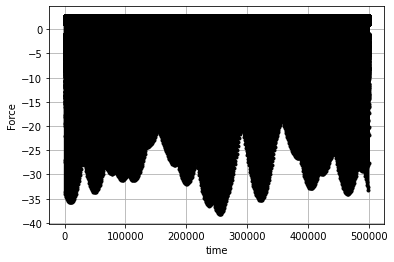

<Figure size 432x288 with 0 Axes>

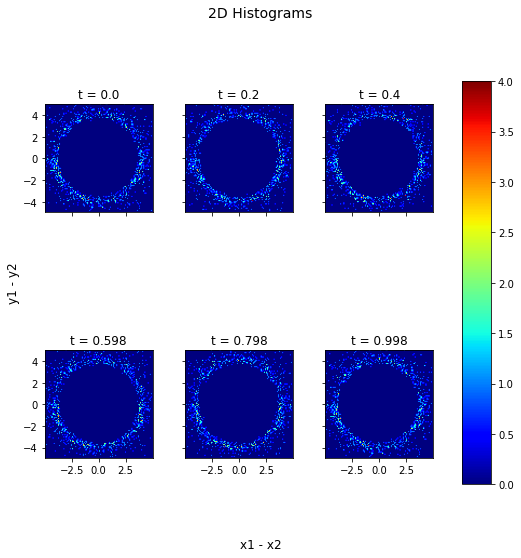

Time of graph data = 0.03815951744715373 min


<Figure size 432x288 with 0 Axes>

In [11]:
 
import matplotlib.pyplot as plt 

# Plot the force versus time
plt.figure(1)
plt.plot(sav['F'].ravel(), '.-k')
plt.xlabel('time')
plt.ylabel('Force')
plt.grid(True)

nTotal = 6       # Total number of subplot
nRow = 2         # Number of row       

# Plot the density of the simulation box 
tic = time.time()
dataGraph(sav, pbc, nRow, nTotal)
tt = (time.time() - tic) / 60
print(f'Time of graph data = {tt} min')
 